In [1]:
import numpy as np
import csv
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
with open('mnist_train.csv', newline='') as f:
    reader = csv.reader(f)
    data = list(reader)

data = data[1:]
data = [a[1:] for a in data]

In [3]:
xs = np.array(data).reshape((60000, 28, 28, 1)).astype(int)/255
ys = xs

print(xs.shape)
print(ys.shape)

(60000, 28, 28, 1)
(60000, 28, 28, 1)


In [ ]:
import pickle

with open('./xs','wb') as f: pickle.dump(xs, f)
with open('./ys','wb') as f: pickle.dump(ys, f)

In [ ]:
l = tf.keras.layers

model = tf.keras.models.Sequential([
    l.Conv2D(filters=4, kernel_size=3, padding='valid', input_shape=(28, 28, 1)),
    l.Conv2D(filters=2, kernel_size=3, padding='valid'),
    l.Conv2D(filters=1, kernel_size=3, padding='valid'),
    l.Conv2D(filters=1, kernel_size=3, padding='valid'),

    l.Flatten(),

    l.Dense(100, activation='relu'),
    l.Dropout(0.3),


    l.Dense(2, activation='tanh'),


    l.Dense(100, activation='relu'),
    l.Dropout(0.3),

    l.Dense(20*20*4, activation='relu'),
    l.Reshape((20, 20, 4)),

    l.Conv2DTranspose(filters=4, kernel_size=3, padding='valid'),
    l.Conv2DTranspose(filters=2, kernel_size=3, padding='valid'),
    l.Conv2DTranspose(filters=1, kernel_size=3, padding='valid'),
    l.Conv2DTranspose(filters=1, kernel_size=3, padding='valid')
])

model.summary()

model.compile(optimizer='adam', loss='mse')

In [ ]:
model.summary()

In [ ]:
plt.imshow(xs[1])
plt.show()

x = np.array([xs[1]])
plt.imshow(model.predict(x)[0])
plt.show()

In [ ]:
model.fit(xs, ys)

In [ ]:
model.save('./model.h5')

In [4]:
model = tf.keras.models.load_model('./model.h5')

In [5]:
l = tf.keras.layers

encoder = tf.keras.models.Sequential([
    l.Conv2D(filters=4, kernel_size=3, padding='valid', input_shape=(28, 28, 1)),
    l.Conv2D(filters=2, kernel_size=3, padding='valid'),
    l.Conv2D(filters=1, kernel_size=3, padding='valid'),
    l.Conv2D(filters=1, kernel_size=3, padding='valid'),

    l.Flatten(),

    l.Dense(100, activation='relu'),
    l.Dropout(0.3),


    l.Dense(2, activation='tanh')
])

encoder.summary()

for i in range(8):
    encoder.layers[i].set_weights(model.layers[i].get_weights())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 4)         40        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 2)         74        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 22, 1)         19        
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 20, 1)         10        
_________________________________________________________________
flatten (Flatten)            (None, 400)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               40100     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0

In [ ]:
out = encoder.predict(xs[:500]).reshape(2, 500)

plt.scatter(out[0],out[1])
plt.show()

In [6]:
l = tf.keras.layers

decoder = tf.keras.models.Sequential([
    l.Dense(100, activation='relu', input_shape=(2,)),
    l.Dropout(0.3),

    l.Dense(20*20*4, activation='relu'),
    l.Reshape((20, 20, 4)),

    l.Conv2DTranspose(filters=4, kernel_size=3, padding='valid'),
    l.Conv2DTranspose(filters=2, kernel_size=3, padding='valid'),
    l.Conv2DTranspose(filters=1, kernel_size=3, padding='valid'),
    l.Conv2DTranspose(filters=1, kernel_size=3, padding='valid')
])

decoder.summary()

for i in range(8):
    decoder.layers[i].set_weights(model.layers[i+8].get_weights())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 100)               300       
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1600)              161600    
_________________________________________________________________
reshape (Reshape)            (None, 20, 20, 4)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 22, 22, 4)         148       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 24, 24, 2)         74        
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 26, 26, 1)        

In [ ]:
out = decoder.predict(np.array([[-1, -0.5]]))[0]

plt.imshow(out)
plt.show()

In [ ]:
from PIL import Image
from tqdm import tqdm

final_img = Image.new('RGB', (4000, 4000), color='black')


for i in tqdm(range(5000)):
    # i = int(np.random.random()*60000)

    prediction = encoder.predict(np.array([xs[i]]))[0]
    prediction = (prediction + 1)/2
    prediction = prediction*4000
    prediction = np.uint32(prediction)

    img = [[[xs[i][y][x],xs[i][y][x],xs[i][y][x]] for x in range(28)] for y in range(28)]
    img = np.array(img)
    img = img.reshape((28,28,3))
    img = np.uint8(255 - img*255)
    img = Image.fromarray(img)
    img = img.resize((100,100))


    final_img.paste(img, (prediction[0],prediction[1]))



final_img.save('./using_mnist.jpg')

In [10]:
from PIL import Image
from tqdm import tqdm

final_img = Image.new('RGB', (4000, 4000), color='black')


for x in tqdm(range(40)):
    for y in range(40):
        X = np.array([[(x-20)/20,(y-20)/20]])


        prediction = decoder.predict(X)[0]
        prediction = np.clip(prediction, 0, 1)
        # print(prediction)

        img = [[[prediction[y][x],prediction[y][x],prediction[y][x]] for x in range(28)] for y in range(28)]
        img = np.array(img)
        img = img.reshape((28,28,3))
        img = np.uint8(255 - img*255)
        img = Image.fromarray(img)
        img = img.resize((100,100))


        final_img.paste(img, (x*100,y*100))



final_img.save('./auto_generated.jpg')

100%|██████████| 40/40 [01:09<00:00,  1.73s/it]


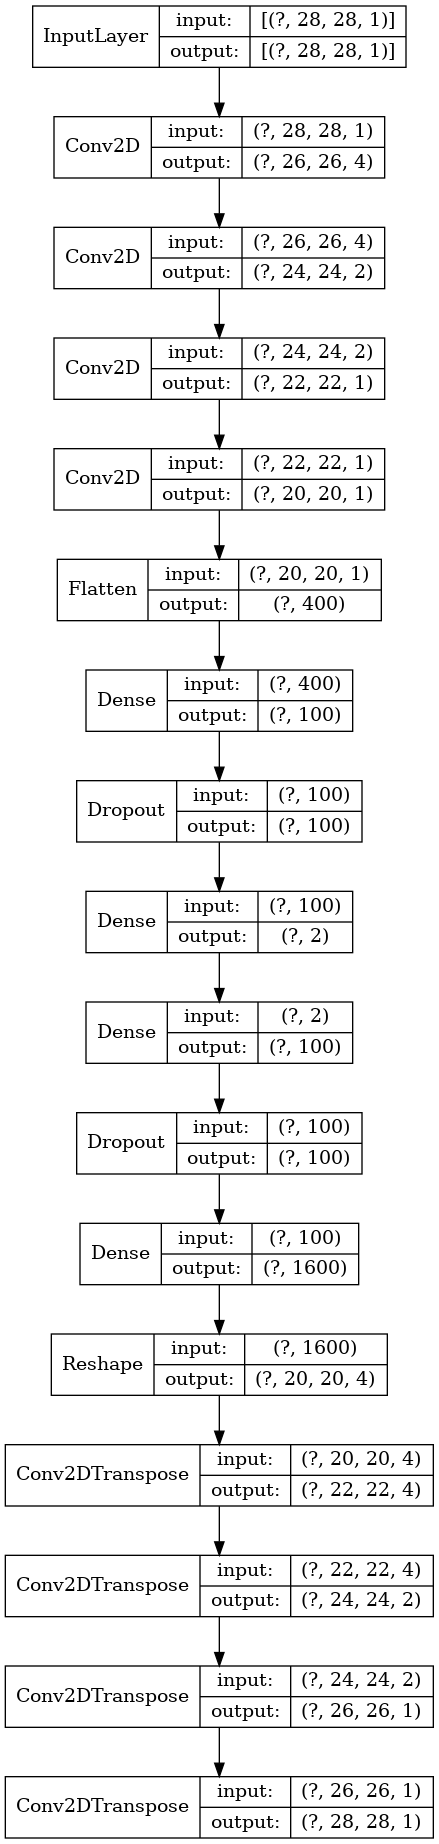

In [13]:
tf.keras.utils.plot_model(model, show_layer_names=False, show_shapes=True, to_file='./model.png')

In [12]:
tf.keras.utils.model_to_dot(model, show_layer_names=False, show_shapes=True)